## Clinical Natural Language Processing: Predicting Hospital Readmission with Discharge Summaries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
import os.path
import string

# Step 1: Prepare data for a machine learning project

In [1]:
from google.colab import files
uploaded = files.upload()

Saving ADMISSIONS.csv to ADMISSIONS.csv


In this project, we will make use of the following MIMIC III tables

```
# This is formatted as code
```


*  ADMISSIONS — a table containing admission and discharge dates (has a unique identifier HADM_ID for each admission)
*   NOTEEVENTS — contains all notes for each hospitalization (links with HADM_ID)


In [4]:
df_adm = pd.read_csv('ADMISSIONS.csv')

The main columns of interest in this table are :
*   SUBJECT_ID: unique identifier for each subject
*   HADM_ID: unique identifier for each hospitalization
*   ADMITTIME: admission date with format YYYY-MM-DD hh:mm:ss
*   DISCHTIME: discharge date with same format
*   DEATHTIME: death time (if it exists) with same format
*   ADMISSION_TYPE: includes ELECTIVE, EMERGENCY, NEWBORN, URGENT

In [5]:
df_adm.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,SEPSIS,1,1
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,NaN,CATHOLIC,DIVORCED,WHITE,NaN,NaN,ALCOHOLIC HEPATITIS,1,1


In [6]:
df_adm.columns

Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data'],
      dtype='object')

The next step is to convert the dates from their string format into a datetime. We use the errors = ‘coerce’ flag to allow for missing dates.

In [ ]:
# convert to dates
df_adm.ADMITTIME = pd.to_datetime(df_adm.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DISCHTIME = pd.to_datetime(df_adm.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
df_adm.DEATHTIME = pd.to_datetime(df_adm.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [ ]:
# check to see if there are any missing dates
print('Number of missing date admissions:', df_adm.ADMITTIME.isnull().sum())
print('Number of missing date discharges:', df_adm.DISCHTIME.isnull().sum())

Number of missing date admissions: 0
Number of missing date discharges: 0


The next step is to get the next unplanned admission date if it exists. This will follow a few steps, and I’ll show you what happens for an artificial patient. First we will sort the dataframe by the admission date

In [ ]:
# sort by subject_ID and admission date
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])
df_adm = df_adm.reset_index(drop = True)
df_adm.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1
1,2,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1
2,3,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1
3,4,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaT,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1
4,5,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1


In [ ]:
df_adm.groupby(['ADMISSION_TYPE']).size()


ADMISSION_TYPE
ELECTIVE      7706
EMERGENCY    42071
NEWBORN       7863
URGENT        1336
dtype: int64

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY
167,124,2165-05-21 21:02:00,ELECTIVE
168,124,2165-12-31 18:55:00,EMERGENCY


We can use the groupby shift operator to get the next admission (if it exists) for each SUBJECT_ID



In [ ]:
# add the next admission date and type for each subject using groupby
# you have to use groupby otherwise the dates will be from different subjects
df_adm['NEXT_ADMITTIME'] = df_adm.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
# get the next admission type
df_adm['NEXT_ADMISSION_TYPE'] = df_adm.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,2165-05-21 21:02:00,ELECTIVE
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


But, we want to predict UNPLANNED re-admissions, so we should filter out the ELECTIVE next admissions.

In [ ]:
# get rows where next admission is elective and replace with naT or nan
rows = df_adm.NEXT_ADMISSION_TYPE == 'ELECTIVE'
df_adm.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
df_adm.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,NaT,NaN
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


We can then calculate the days until the next admission


In [ ]:
# sort by subject_ID and admission date
# it is safer to sort right before the fill incase something changed the order above
df_adm = df_adm.sort_values(['SUBJECT_ID','ADMITTIME'])

# back fill (this will take a little while)
df_adm[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = df_adm.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE
165,124,2160-06-24 21:25:00,EMERGENCY,2161-12-17 03:39:00,EMERGENCY
166,124,2161-12-17 03:39:00,EMERGENCY,2165-12-31 18:55:00,EMERGENCY
167,124,2165-05-21 21:02:00,ELECTIVE,2165-12-31 18:55:00,EMERGENCY
168,124,2165-12-31 18:55:00,EMERGENCY,NaT,NaN


In [ ]:
# verify that it did what we wanted
df_adm.loc[df_adm.SUBJECT_ID == 124,['SUBJECT_ID','ADMITTIME','ADMISSION_TYPE','DISCHTIME','NEXT_ADMITTIME','NEXT_ADMISSION_TYPE', 'DAYS_NEXT_ADMIT']]

,SUBJECT_ID,ADMITTIME,ADMISSION_TYPE,DISCHTIME,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT
165,124,2160-06-24 21:25:00,EMERGENCY,2160-07-15 15:10:00,2161-12-17 03:39:00,EMERGENCY,519.520139
166,124,2161-12-17 03:39:00,EMERGENCY,2161-12-24 15:35:00,2165-12-31 18:55:00,EMERGENCY,1468.138889
167,124,2165-05-21 21:02:00,ELECTIVE,2165-06-06 16:00:00,2165-12-31 18:55:00,EMERGENCY,208.121528
168,124,2165-12-31 18:55:00,EMERGENCY,2166-02-01 06:55:00,NaT,NaN,NaN


In [ ]:
# calculate the number of days between discharge and next admission
df_adm['DAYS_NEXT_ADMIT']=  (df_adm.NEXT_ADMITTIME - df_adm.DISCHTIME).dt.total_seconds()/(24*60*60)

In our dataset with 58976 hospitalizations, there are 11399 re-admissions. For those with a re-admission, we can plot the histogram of days between admissions.

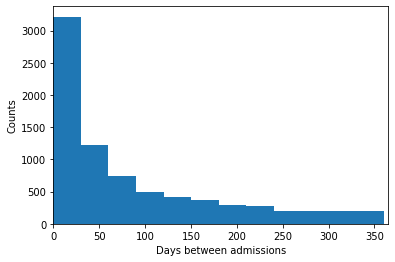

In [ ]:
# plot a histogram of days between readmissions if they exist
# this only works for non-null values so you have to filter
plt.hist(df_adm.loc[~df_adm.DAYS_NEXT_ADMIT.isnull(),'DAYS_NEXT_ADMIT'], bins =range(0,365,30))
plt.xlim([0,365])
plt.xlabel('Days between admissions')
plt.ylabel('Counts')
plt.show()

In [ ]:
print('Number with a readmission:', (~df_adm.DAYS_NEXT_ADMIT.isnull()).sum())
print('Total Number:', len(df_adm))

Number with a readmission: 11399
Total Number: 58976


In [ ]:
# it takes around 2 hours to load the noteevents table
from google.colab import files
uploaded = files.upload()


Saving NOTEEVENTS.csv.gz to NOTEEVENTS.csv.gz


In [ ]:
df_notes = pd.read_csv("NOTEEVENTS.csv.gz")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The main columns of interest are:
*   SUBJECT_ID
*   HADM_ID
*   CATEGORY: includes ‘Discharge summary’, ‘Echo’, ‘ECG’, ‘Nursing’, ‘Physician ‘, ‘Rehab Services’, ‘Case Management ‘, ‘Respiratory ‘, ‘Nutrition’, ‘General’, ‘Social Work’, ‘Pharmacy’, ‘Consult’, ‘Radiology’,
‘Nursing/other’
*   TEXT: our clinical notes column

In [ ]:
print('Number of notes:',len(df_notes))

Number of notes: 2083180


In [ ]:
list(df_notes)

['ROW_ID',
 'SUBJECT_ID',
 'HADM_ID',
 'CHARTDATE',
 'CHARTTIME',
 'STORETIME',
 'CATEGORY',
 'DESCRIPTION',
 'CGID',
 'ISERROR',
 'TEXT']

In [ ]:
df_notes.head()


,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [ ]:
df_notes.CATEGORY.unique()

array(['Discharge summary', 'Echo', 'ECG', 'Nursing', 'Physician ',
       'Rehab Services', 'Case Management ', 'Respiratory ', 'Nutrition',
       'General', 'Social Work', 'Pharmacy', 'Consult', 'Radiology',
       'Nursing/other'], dtype=object)

In [ ]:
# look at the first note
df_notes.TEXT.iloc[0]

'Admission Date:  [**2151-7-16**]       Discharge Date:  [**2151-8-4**]\n\n\nService:\nADDENDUM:\n\nRADIOLOGIC STUDIES:  Radiologic studies also included a chest\nCT, which confirmed cavitary lesions in the left lung apex\nconsistent with infectious process/tuberculosis.  This also\nmoderate-sized left pleural effusion.\n\nHEAD CT:  Head CT showed no intracranial hemorrhage or mass\neffect, but old infarction consistent with past medical\nhistory.\n\nABDOMINAL CT:  Abdominal CT showed lesions of\nT10 and sacrum most likely secondary to osteoporosis. These can\nbe followed by repeat imaging as an outpatient.\n\n\n\n                            [**First Name8 (NamePattern2) **] [**First Name4 (NamePattern1) 1775**] [**Last Name (NamePattern1) **], M.D.  [**MD Number(1) 1776**]\n\nDictated By:[**Hospital 1807**]\nMEDQUIST36\n\nD:  [**2151-8-5**]  12:11\nT:  [**2151-8-5**]  12:21\nJOB#:  [**Job Number 1808**]\n'

In [ ]:

# filter to discharge summary
df_notes_dis_sum = df_notes.loc[df_notes.CATEGORY == 'Discharge summary']

Since I can’t show individual notes, I will just describe them here. The dataset has 2,083,180 rows, indicating that there are multiple notes per hospitalization. In the notes, the dates and PHI (name, doctor, location) have been converted for confidentiality. There are also special characters such as \n (new line), numbers and punctuation.
Since there are multiple notes per hospitalization, we need to make a choice on what notes to use. For simplicity, let’s use the discharge summary, but we could use all the notes by concatenating them if we wanted.

In [1]:
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

NameError: ignored

At this point, you might want to investigate why there are multiple summaries, but for simplicity let’s just use the last one

In [ ]:
df_notes_dis_sum_last = (df_notes_dis_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert df_notes_dis_sum_last.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

Now we are ready to merge the admissions and notes tables. I use a left merge to account for when notes are missing. There are a lot of cases where you get multiple rows after a merge(although we dealt with it above), so I like to add assert statements after a merge

In [ ]:

df_adm_notes = pd.merge(df_adm[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_NEXT_ADMIT','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        df_notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
assert len(df_adm) == len(df_adm_notes), 'Number of rows increased'

In [ ]:
len(df_adm)

58976

In [ ]:
len(df_adm_notes)

58976

In [ ]:
df_adm_notes.TEXT.isnull().sum()

6250

In [ ]:

print('Fraction of missing notes:', df_adm_notes.TEXT.isnull().sum() / len(df_adm_notes))
print('Fraction notes with newlines:', df_adm_notes.TEXT.str.contains('\n').sum() / len(df_adm_notes))
print('Fraction notes with carriage returns:', df_adm_notes.TEXT.str.contains('\r').sum() / len(df_adm_notes))

Fraction of missing notes: 0.1059753119913185
Fraction notes with newlines: 0.8940246880086815
Fraction notes with carriage returns: 0.0


10.6 % of the admissions are missing (df_adm_notes.TEXT.isnull().sum() / len(df_adm_notes)), so I investigated a bit further with

In [ ]:
df_adm_notes.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/df_adm_notes.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048663
EMERGENCY    0.037983
NEWBORN      0.536691
URGENT       0.042665
dtype: float64

In [ ]:

df_adm_notes_clean = df_adm_notes.loc[df_adm_notes.ADMISSION_TYPE != 'NEWBORN'].copy()

In [ ]:
print('Fraction of missing notes:', df_adm_notes_clean.TEXT.isnull().sum() / len(df_adm_notes_clean))
print('Fraction notes with newlines:', df_adm_notes_clean.TEXT.str.contains('\n').sum() / len(df_adm_notes_clean))
print('Fraction notes with carriage returns:', df_adm_notes_clean.TEXT.str.contains('\r').sum() / len(df_adm_notes_clean))

Fraction of missing notes: 0.03971592354195606
Fraction notes with newlines: 0.9602840764580439
Fraction notes with carriage returns: 0.0


and discovered that 53% of the NEWBORN admissions were missing discharge summaries vs ~4% for the others. At this point I decided to remove the NEWBORN admissions. Most likely, these missing NEWBORN admissions have their discharge summary stored outside of the MIMIC dataset.
For this problem, we are going to classify if a patient will be admitted in the next 30 days. Therefore, we need to create a variable with the output label (1 = readmitted, 0 = not readmitted)

In [ ]:
df_adm_notes_clean['OUTPUT_LABEL'] = (df_adm_notes_clean.DAYS_NEXT_ADMIT < 30).astype('int')

In [ ]:

print('Number of positive samples:', (df_adm_notes_clean.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (df_adm_notes_clean.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(df_adm_notes_clean))

Number of positive samples: 3004
Number of negative samples: 48109
Total samples: 51113


A quick count of positive and negative results in 3004 positive samples, 48109 negative samples. This indicates that we have an imbalanced dataset, which is a common occurrence in healthcare data science.
The last step to prepare our data is to split the data into training, validation and test sets. For reproducible results, I have made the random_state always 42.

In [ ]:
# shuffle the samples
df_adm_notes_clean = df_adm_notes_clean.sample(n = len(df_adm_notes_clean), random_state = 42)
df_adm_notes_clean = df_adm_notes_clean.reset_index(drop = True)

# Save 30% of the data as validation and test data 
df_valid_test=df_adm_notes_clean.sample(frac=0.30,random_state=42)

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# use the rest of the data as training data
df_train_all=df_adm_notes_clean.drop(df_valid_test.index)

print('Test prevalence(n = %d):'%len(df_test),df_test.OUTPUT_LABEL.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.OUTPUT_LABEL.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.OUTPUT_LABEL.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(df_adm_notes_clean))
assert len(df_adm_notes_clean) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

Test prevalence(n = 7667): 0.061953828094430674
Valid prevalence(n = 7667): 0.056997521846876224
Train all prevalence(n = 35779): 0.05847005226529529
all samples (n = 51113)


Since the prevalence is so low, we want to prevent the model from always predicting negative (not re-admitted). To do this, we have a few options to balance the training data


*   sub-sampling the negatives
*   over-sampling the positives
*   create synthetic data (e.g. SMOTE)

Since I didn’t make any restrictions on size of RAM for your computer, we will sub-sample the negatives, but I encourage you to try out the other techniques if your computer or server can handle it to see if you can get an improvement. 

In [ ]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(df_train), df_train.OUTPUT_LABEL.sum()/ len(df_train))

Train prevalence (n = 4184): 0.5


# Step 2: Preprocess the unstructured notes using a bag-of-words approach

Now that we have created data sets that have a label and the notes, we need to preprocess our text data to convert it to something useful (i.e. numbers) for the machine learning model. We are going to use the Bag-of-Words (BOW) approach.

In [ ]:

def preprocess_text(df):
    # This function preprocesses the text by filling not a number and replacing new lines ('\n') and carriage returns ('\r')
    df.TEXT = df.TEXT.fillna(' ')
    df.TEXT =df.TEXT.str.replace('\n',' ')
    df.TEXT =df.TEXT.str.replace('\r',' ')
    return df

In [ ]:
# preprocess the text to deal with known issues
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In this process, there are few choices that need to be made
*   how to preprocess the words
*   how to count the words
*   which words to use

There is no optimal choice for all NLP projects, so I recommend trying out a few options when building your own models.

You can do the preprocessing in two ways
*   modify the original dataframe TEXT column
*   preprocess as part of your pipeline so you don’t edit the original data

Let’s define a function that will modify the original dataframe by filling missing notes with space and removing newline and carriage returns

The other option is to preprocess as part of the pipeline. This process consists of using a tokenizer and a vectorizer. The tokenizer breaks a single note into a list of words and a vectorizer takes a list of words and counts the words.
We will use word_tokenize from the nltk package for our default tokenizer, which basically breaks the note based on spaces and some punctuation. An example is shown below:

With output:


In [ ]:

import nltk
from nltk import word_tokenize
word_tokenize('This should be tokenized. 02/02/2018 sentence has stars**')

['This',
 'should',
 'be',
 'tokenized',
 '.',
 '02/02/2018',
 'sentence',
 'has',
 'stars**']

In [ ]:

import string
print(string.punctuation)


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


The default shows that some punctuation is separated and that numbers stay in the sentence. We will write our own tokenizer function to


*   replace punctuation with spaces
*   replace numbers with spaces
*   lower case all words

In [ ]:

def tokenizer_better(text):
    # tokenize the text by replacing punctuation and numbers with spaces and lowercase all words
    
    punc_list = string.punctuation+'0123456789'
    t = str.maketrans(dict.fromkeys(punc_list, " "))
    text = text.lower().translate(t)
    tokens = word_tokenize(text)
    return tokens

With this tokenizer we get from our original sentence


In [ ]:
tokenizer_better('This should be tokenized. 02/02/2018 sentence has stars**')

['this', 'should', 'be', 'tokenized', 'sentence', 'has', 'stars']

Now that we have a way to convert free-text into tokens, we need a way to count the tokens for each discharge summary. We will use the built in CountVectorizer from scikit-learn package. This vectorizer simply counts how many times each word occurs in the note. There is also a TfidfVectorizer which takes into how often words are used across all notes, but for this project let’s use the simpler one (I got similar results with the second one too).
As an example, let’s say we have 3 notes

In [ ]:
sample_text = ['Data science is about the data', 'The science is amazing', 'Predictive modeling is part of data science']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer = tokenizer_better)
vect.fit(sample_text)

# matrix is stored as a sparse matrix (since you have a lot of zeros)
X = vect.transform(sample_text)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [ ]:
X

<3x10 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [ ]:
# we can visualize this small example if we convert it to an array
X.toarray()

array([[1, 0, 2, 1, 0, 0, 0, 0, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0]])

In [ ]:

# get the column names
vect.get_feature_names()

['about',
 'amazing',
 'data',
 'is',
 'modeling',
 'of',
 'part',
 'predictive',
 'science',
 'the']

Essentially, you fit the CountVectorizer to learn the words in your data and the transform your data to create counts for each word.

The matrix X will be a sparse matrix, but if you convert it to an array (X.toarray()), you will see this

Where there are 3 rows (since we have 3 notes) and counts of each word. You can see the column names with vect.get_feature_names()

We can now fit our CountVectorizer on the clinical notes. It is important to use only the training data because you don’t want to include any new words that show up in the validation and test sets. There is a hyperparameter called max_features which you can set to constrain how many words are included in the Vectorizer. This will use the top N most frequently used words. In step 5, we will adjust this to see its effect.

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, tokenizer = tokenizer_better)

# this could take a while
vect.fit(df_train.TEXT.values)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenizer_better at 0x7efcf7dd9158>,
                vocabulary=None)

We can look at the most frequently used words and we will see that many of these words might not add any value for our model. These words are called stop words, and we can remove them easily (if we want) with the CountVectorizer. There are lists of common stop words for different NLP corpus, but we will just make up our own based on the image below.


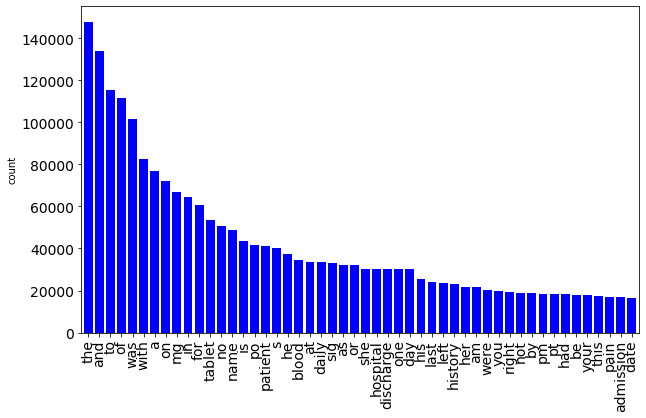

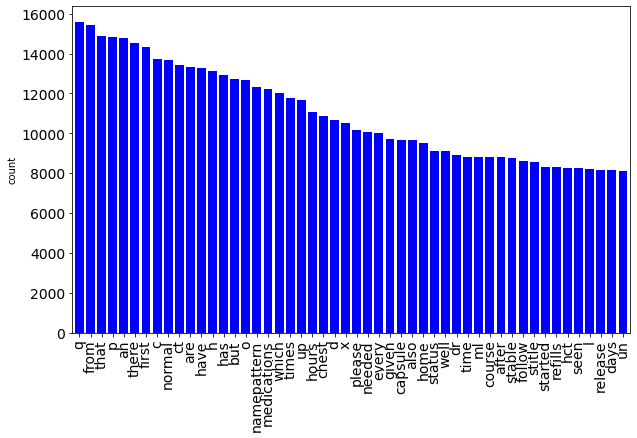

In [ ]:
neg_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 0].TEXT)
pos_doc_matrix = vect.transform(df_train[df_train.OUTPUT_LABEL == 1].TEXT)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],columns=vect.get_feature_names()).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

#Create a series from the sparse matrix
d = pd.Series(term_freq_df.total, 
              index = term_freq_df.index).sort_values(ascending=False)
ax = d[:50].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()
ax = d[50:100].plot(kind='bar', figsize=(10,6), width=.8, fontsize=14, rot=90,color = 'b')
ax.title.set_size(18)
plt.ylabel('count')
plt.show()

In [ ]:

my_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(max_features = 3000, 
                       tokenizer = tokenizer_better, 
                       stop_words = my_stop_words)
# this could take a while
vect.fit(df_train.TEXT.values)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['the', 'and', 'to', 'of', 'was', 'with', 'a', 'on',
                            'in', 'for', 'name', 'is', 'patient', 's', 'he',
                            'at', 'as', 'or', 'one', 'she', 'his', 'her', 'am',
                            'were', 'you', 'pt', 'pm', 'by', 'be', 'had', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function tokenizer_better at 0x7efcf7dd9158>,
                vocabulary=None)

Now we can transform our notes into numerical matrices. At this point, I will only use the training and validation data so I’m not tempted to see how it works on the test data yet.


In [ ]:
X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)

We also need our output labels as separate variables


In [ ]:
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

# Step 3: Build a simple predictive 

We can now build a simple predictive model that takes our bag-of-words inputs and predicts if a patient will be readmitted in 30 days (YES = 1, NO = 0).
Here we will use the Logistic Regression model. Logistic regression is a good baseline model for NLP tasks since it works well with sparse matrices and is interpretable. We have a few additional choices (called hyperparameters) including C which is a coefficient on regularization and penalty which tells how to measure the regularization. Regularization is essentially a technique to try to minimize overfitting.


In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We can calculate the probability of readmission for each sample with the fitted model

In [ ]:
model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

# Step 4: Assess the quality of your model


At this point, we need to measure how well our model performed. There are a few different data science performance metrics. I wrote another blog post explaining these in detail if you are interested. Since this post is quite long now, I will start just showing results and figures. You can see the github account for the code to produce the figures.


In [ ]:
print(y_train[:10].values)
print(y_train_preds[:10])

[1 1 0 1 1 1 0 0 1 1]
[0.42013987 0.4360379  0.28809073 0.6238073  0.24422986 0.45490439
 0.33683096 0.91645687 0.69387608 0.50733574]


With the current selection of hyperparameters, we do have some overfitting. One thing to point out is that the major difference between the precision in the two sets of data is due to the fact that we balanced the training set, where as the validation set is the original distribution. Currently, if we make a list of patients predicted to be readmitted we catch twice as many of them as if we randomly selected patients (PRECISION vs PREVALENCE).
Another performance metric not shown above is AUC or area under the ROC curve. The ROC curve for our current model is shown below. Essentially the ROC curve allows you to see the trade-off between true positive rate and false positive rate as you vary the threshold on what you define as predicted positive vs predicted negative.

In [ ]:

def calc_accuracy(y_actual, y_pred, thresh):
    # this function calculates the accuracy with probability threshold at thresh
    return (sum((y_pred > thresh) & (y_actual == 1))+sum((y_pred < thresh) & (y_actual == 0))) /len(y_actual)

def calc_recall(y_actual, y_pred, thresh):
    # calculates the recall
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_actual)

def calc_precision(y_actual, y_pred, thresh):
    # calculates the precision
    return sum((y_pred > thresh) & (y_actual == 1)) /sum(y_pred > thresh)

def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

Train AUC:0.754
Valid AUC:0.706
Train accuracy:0.685
Valid accuracy:0.714
Train recall:0.624
Valid recall:0.595
Train precision:0.712
Valid precision:0.114
Train specificity:0.747
Valid specificity:0.721
Train prevalence:0.500
Valid prevalence:0.057


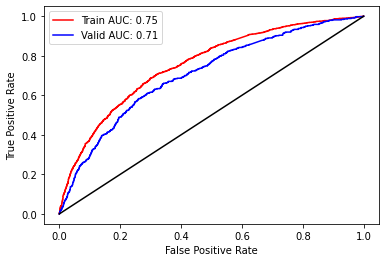

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)


thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))

print('Train prevalence:%.3f'%calc_prevalence(y_train))
print('Valid prevalence:%.3f'%calc_prevalence(y_valid))


plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Step 5: Next steps for improving the model


At this point, you might be tempted to calculate the performance on your test set and see how you did. We made many choices (a few below) which we could change and see if there is an improvement:

*   should we spend time getting more data?
*   how to tokenize — should we use stemming?
*   how to vectorize — should we change the number of words?
*   how to regularized the logistic regression — should we change C or penalty?
*   which model to use?


For NLP projects that use BOW+logistic regression, we can plot the most important words to see if we can gain any insight. For this step, I borrowed code from a nice NLP article by Insight Data Science. When you look at the most important words, I see two immediate things:

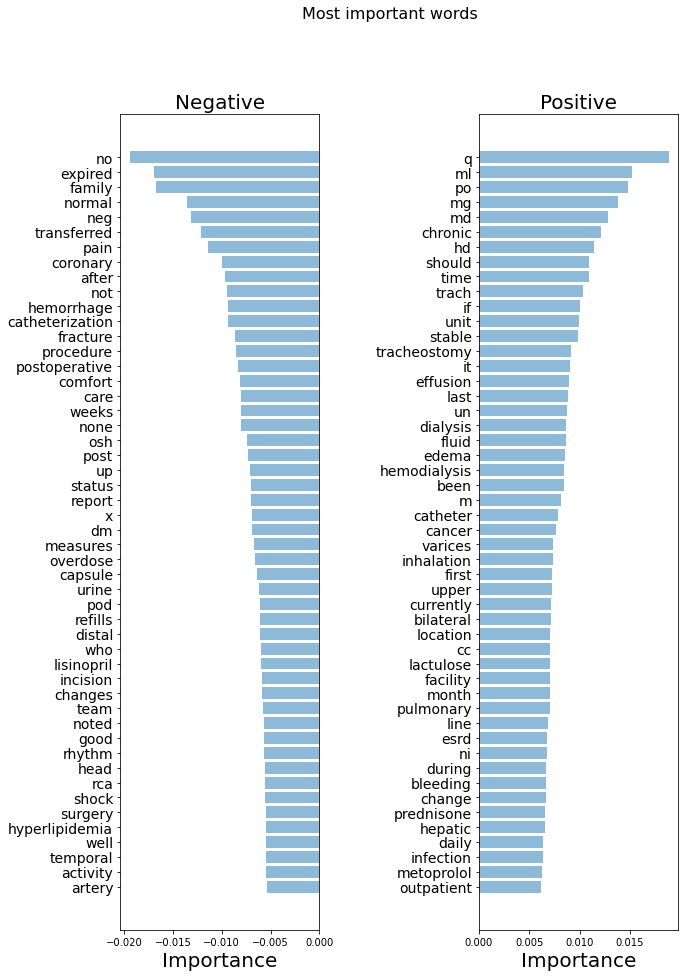

In [ ]:

def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 15))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

    
importance = get_most_important_features(vect, clf, 50)
    
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words")

In [ ]:

my_new_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also','should','if','it','been','who','during', 'x']

In [ ]:
vect = CountVectorizer(lowercase = True, max_features = 3000, tokenizer = tokenizer_better,stop_words =my_new_stop_words)
#
# This could take a while
vect.fit(df_train.TEXT.values)

X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [ ]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

When we want to improve the model, we want to do it in a data-driven manner. You can spend a lot of time on ‘hunches’, that don’t end up panning out. To do this, it is recommend to pick a single performance metric that you use to make your decisions. For this project, I am going to pick AUC.
For the first question above, we can plot something called a Learning Curve to understand the effect of adding more data. 

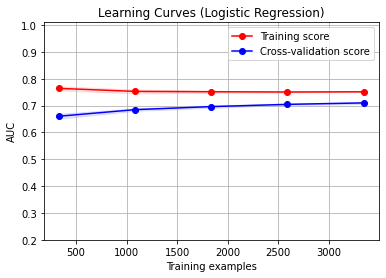

In [ ]:

title = "Learning Curves (Logistic Regression)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = LogisticRegression( C = 0.0001, penalty = 'l2')
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

Cs = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003]
train_aucs = np.zeros(len(Cs))
valid_aucs = np.zeros(len(Cs))

for ii in range(len(Cs)):
    C = Cs[ii]
    print('\n C:', C)
    
    # logistic regression
    
    clf=LogisticRegression(C = C, penalty = 'l2', random_state = 42)
    clf.fit(X_train_tf, y_train)

    model = clf
    y_train_preds = model.predict_proba(X_train_tf)[:,1]
    y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC:%.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid


 C: 1e-05
Train AUC:0.681
Valid AUC:0.671

 C: 3e-05
Train AUC:0.712
Valid AUC:0.687

 C: 0.0001
Train AUC:0.753
Valid AUC:0.707

 C: 0.0003
Train AUC:0.796
Valid AUC:0.720

 C: 0.001


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train AUC:0.852
Valid AUC:0.721

 C: 0.003
Train AUC:0.904
Valid AUC:0.707


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


We can see that we have some overfitting but adding more data is likely not going to drastically change the AUC on a validation set. This is good to know because it means we shouldn’t spend months getting more data.
Some simple things that we can do is try to see the effect of some of our hyperparameters (max_features and C). We could run a grid search, but since we only have 2 parameters here we could look at them separately and see the effect.


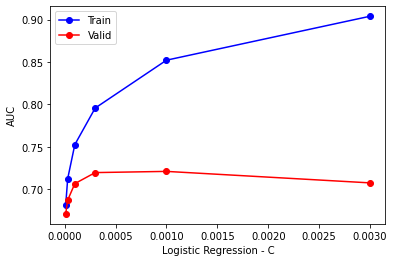

In [ ]:

plt.plot(Cs, train_aucs,'bo-', label ='Train')
plt.plot(Cs, valid_aucs, 'ro-', label='Valid')
plt.legend()
plt.xlabel('Logistic Regression - C')
plt.ylabel('AUC')
plt.show()

In [ ]:
num_features = [100,300,1000,3000,10000,30000]
train_aucs = np.zeros(len(num_features))
valid_aucs = np.zeros(len(num_features))

for ii in range(len(num_features)):
    num = num_features[ii]
    print('\nnumber of features:', num)
    vect = CountVectorizer(lowercase = True, max_features = num, 
                           tokenizer = tokenizer_better,stop_words =my_new_stop_words)

    # This could take a while
    vect.fit(df_train.TEXT.values)

    X_train_tf = vect.transform(df_train.TEXT.values)
    X_valid_tf = vect.transform(df_valid.TEXT.values)
    y_train = df_train.OUTPUT_LABEL
    y_valid = df_valid.OUTPUT_LABEL
    
    clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
    clf.fit(X_train_tf, y_train)

    model = clf
    y_train_preds = model.predict_proba(X_train_tf)[:,1]
    y_valid_preds = model.predict_proba(X_valid_tf)[:,1]

    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)
    print('Train AUC: %.3f'%auc_train)
    print('Valid AUC:%.3f'%auc_valid)
    train_aucs[ii] = auc_train
    valid_aucs[ii] = auc_valid


number of features: 100


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train AUC: 0.686
Valid AUC:0.667

number of features: 300


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train AUC: 0.712
Valid AUC:0.684

number of features: 1000


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train AUC: 0.736
Valid AUC:0.700

number of features: 3000


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train AUC: 0.753
Valid AUC:0.707

number of features: 10000


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train AUC: 0.758
Valid AUC:0.708

number of features: 30000


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train AUC: 0.759
Valid AUC:0.708


We can see that increasing C and max_features, cause the model to overfit pretty quickly. I selected C = 0.0001 and max_features = 3000 where the validation set started to plateau.
At this point, you could try a few other things

*   change sub-sample to over-sample
*   add stemming or lemmatization to the tokenizer
*   test a few different sci-kit learn models
*   concatenate all the notes instead of the last discharge summary
*   try a deep learning method such as LSTMs
*   review the discharge summaries that you are getting wrong

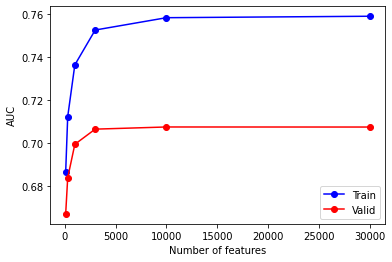

In [ ]:
plt.plot(num_features, train_aucs,'bo-', label ='Train')
plt.plot(num_features, valid_aucs, 'ro-', label='Valid')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('AUC')
plt.show()

# Step 6: Finalize your model and test it


We will now fit our final model with hyperparameter selection. We will also exclude the patients who died with a re-balancing.


In [ ]:
# shuffle the samples

rows_not_death = df_adm_notes_clean.DEATHTIME.isnull()

df_adm_notes_not_death = df_adm_notes_clean.loc[rows_not_death].copy()
df_adm_notes_not_death = df_adm_notes_not_death.sample(n = len(df_adm_notes_not_death), random_state = 42)
df_adm_notes_not_death = df_adm_notes_not_death.reset_index(drop = True)

# Save 30% of the data as validation and test data 
df_valid_test=df_adm_notes_not_death.sample(frac=0.30,random_state=42)

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)

# use the rest of the data as training data
df_train_all=df_adm_notes_not_death.drop(df_valid_test.index)

print('Test prevalence(n = %d):'%len(df_test),df_test.OUTPUT_LABEL.sum()/ len(df_test))
print('Valid prevalence(n = %d):'%len(df_valid),df_valid.OUTPUT_LABEL.sum()/ len(df_valid))
print('Train all prevalence(n = %d):'%len(df_train_all), df_train_all.OUTPUT_LABEL.sum()/ len(df_train_all))
print('all samples (n = %d)'%len(df_adm_notes_clean))
assert len(df_adm_notes_not_death) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train prevalence (n = %d):'%len(df_train), df_train.OUTPUT_LABEL.sum()/ len(df_train))

# preprocess the text to deal with known issues
df_train = preprocess_text(df_train)
df_valid = preprocess_text(df_valid)
df_test = preprocess_text(df_test)

Test prevalence(n = 6798): 0.06590173580464842
Valid prevalence(n = 6798): 0.06913798175934098
Train all prevalence(n = 31725): 0.0644602048857368
all samples (n = 51113)
Train prevalence (n = 4090): 0.5


In [ ]:
my_new_stop_words = ['the','and','to','of','was','with','a','on','in','for','name',
                 'is','patient','s','he','at','as','or','one','she','his','her','am',
                 'were','you','pt','pm','by','be','had','your','this','date',
                'from','there','an','that','p','are','have','has','h','but','o',
                'namepattern','which','every','also','should','if','it','been','who','during', 'x']

from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(lowercase = True, max_features = 3000, 
                       tokenizer = tokenizer_better,
                      stop_words = my_new_stop_words)

# This could take a while
vect.fit(df_train.TEXT.values)

X_train_tf = vect.transform(df_train.TEXT.values)
X_valid_tf = vect.transform(df_valid.TEXT.values)
X_test_tf = vect.transform(df_test.TEXT.values)

y_train = df_train.OUTPUT_LABEL
y_valid = df_valid.OUTPUT_LABEL
y_test = df_test.OUTPUT_LABEL

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

clf=LogisticRegression(C = 0.0001, penalty = 'l2', random_state = 42)
clf.fit(X_train_tf, y_train)

model = clf
y_train_preds = model.predict_proba(X_train_tf)[:,1]
y_valid_preds = model.predict_proba(X_valid_tf)[:,1]
y_test_preds = model.predict_proba(X_test_tf)[:,1]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Train prevalence(n = 4184): 0.500
Valid prevalence(n = 7667): 0.057
Test prevalence(n = 7667): 0.062
Train AUC:0.753
Valid AUC:0.707
Test AUC:0.683
Train accuracy:0.686
Valid accuracy:0.713
Test accuracy:0.709
Train recall:0.623
Valid recall:0.600
Test recall:0.549
Train precision:0.713
Valid precision:0.115
Test precision:0.115
Train specificity:0.749
Valid specificity:0.720
Test specificity:0.719


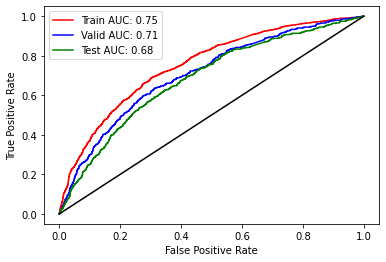

In [ ]:

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)

thresh = 0.5

auc_train = roc_auc_score(y_train, y_train_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

print('Train prevalence(n = %d): %.3f'%(len(y_train),sum(y_train)/ len(y_train)))
print('Valid prevalence(n = %d): %.3f'%(len(y_valid),sum(y_valid)/ len(y_valid)))
print('Test prevalence(n = %d): %.3f'%(len(y_test),sum(y_test)/ len(y_test)))

print('Train AUC:%.3f'%auc_train)
print('Valid AUC:%.3f'%auc_valid)
print('Test AUC:%.3f'%auc_test)

print('Train accuracy:%.3f'%calc_accuracy(y_train, y_train_preds, thresh))
print('Valid accuracy:%.3f'%calc_accuracy(y_valid, y_valid_preds, thresh))
print('Test accuracy:%.3f'%calc_accuracy(y_test, y_test_preds, thresh))


print('Train recall:%.3f'%calc_recall(y_train, y_train_preds, thresh))
print('Valid recall:%.3f'%calc_recall(y_valid, y_valid_preds, thresh))
print('Test recall:%.3f'%calc_recall(y_test, y_test_preds, thresh))

print('Train precision:%.3f'%calc_precision(y_train, y_train_preds, thresh))
print('Valid precision:%.3f'%calc_precision(y_valid, y_valid_preds, thresh))
print('Test precision:%.3f'%calc_precision(y_test, y_test_preds, thresh))

print('Train specificity:%.3f'%calc_specificity(y_train, y_train_preds, thresh))
print('Valid specificity:%.3f'%calc_specificity(y_valid, y_valid_preds, thresh))
print('Test specificity:%.3f'%calc_specificity(y_test, y_test_preds, thresh))

plt.plot(fpr_train, tpr_train,'r-', label = 'Train AUC: %.2f'%auc_train)
plt.plot(fpr_valid, tpr_valid,'b-',label = 'Valid AUC: %.2f'%auc_valid)
plt.plot(fpr_test, tpr_test,'g-',label = 'Test AUC: %.2f'%auc_test)

plt.plot([0,1],[0,1],'-k')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Conclusion

I follow tutorial to built a simple NLP model (AUC = 0.70) to predict re-admission based on hospital discharge summaries that is only slightly worse than the state-of-the-art deep learning method that uses all hospital data (AUC = 0.75). 